# Slingshot Trajectory Tutorial

In [1]:
#Import Statements
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import matplotlib.pyplot as plt
import matplotlib
sc.settings.verbosity = 3 
#sc.logging.print_versions()

import warnings
import os
from matplotlib import rcParams
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures

In [3]:
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

In [4]:
# Ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
# Convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.2.0
anndata2ri          1.0.6
annoy               NA
appnope             0.1.2
backcall            0.2.0
bbknn               NA
cached_property     1.5.2
certifi             2021.05.30
cffi                1.14.5
chardet             4.0.0
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
gprofiler           1.0.0
h5py                3.1.0
idna       

In [5]:
%%R
# Loading R libraries in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(ggbeeswarm)
suppressPackageStartupMessages(library(PseudotimeDE))
library(ComplexHeatmap)
library(tidyverse)

In [6]:
#Reading the AnnData Object with Clusters
cDCs = sc.read('./H5ADs_pCov/cDC_pCov40_07292021.h5ad')
cDCs

AnnData object with n_obs × n_vars = 504 × 1362
    obs: 'Cells', 'Samples', 'IDs', 'Names', 'Fig_ids', 'Groups', 'Ethnicity', 'Age_Months', 'runs_10X', 'Year', 'Patient_groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'Res1_2_BC', 'Res1_2_AC', 'Fig_ids_Groups', 'annotated_clusters', 'ISG_score_raw', 'ISG_score', 'INFLAM_score_raw', 'INFLAM_score', 'CD14_mono_Res1', 'CD14_mono_Res0_8', 'CD14_mono_Res0_6', 'CD14_mono_Res0_4', 'IL1B_IFI27', 'IL1B_ISG15', 'IL1B_XAF1', 'CXCL8_IFI27', 'CXCL8_ISG15', 'CXCL8_XAF1', 'Merged_SCs', 'SCs', 'cDC_Res0_4', 'cDC_Res0_6', 'cDC_Res0_8', 'cDC_Res1'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Groups_colors', 'Patient_groups_colors', 'SCs_colors', 'cDC_Res0_4_colors', 'cDC_Res0_6_colors', 'cDC_Res0_8_colors', 'cDC_Res1_colors', "dendrogram_['CD14_mono_Res0_4']", "dendrogram_['SCs']", "dendrogram_['cDC_Res0_8']", 'leiden', 'ne

# Plotting Clusters & Genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


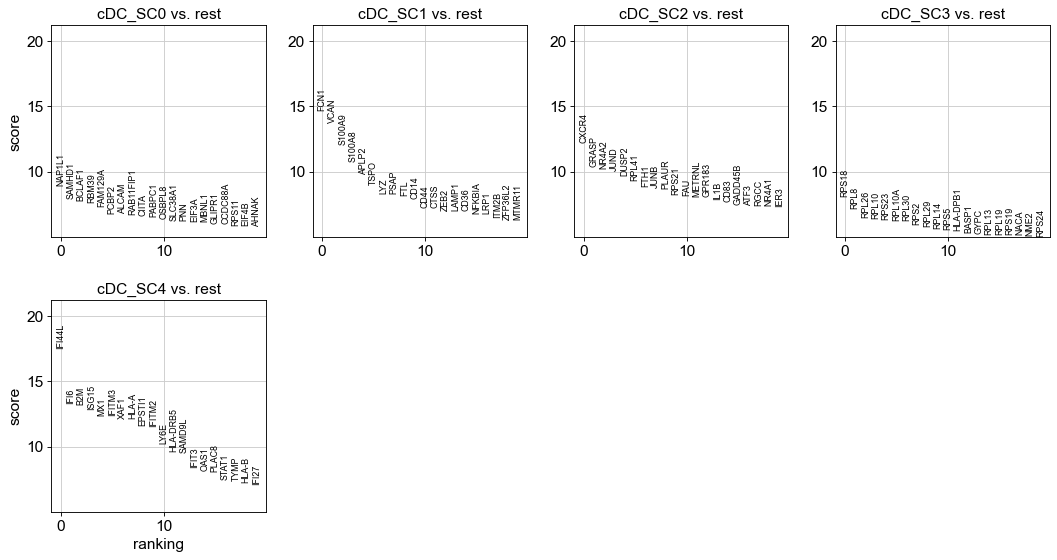

In [7]:
sc.tl.rank_genes_groups(cDCs, groupby='SCs', method='t-test')

rcParams['figure.figsize'] = 4,4
rcParams['axes.grid'] = True
sc.pl.rank_genes_groups(cDCs)

In [8]:
sc.tl.dendrogram(cDCs, groupby='SCs')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_SCs']`


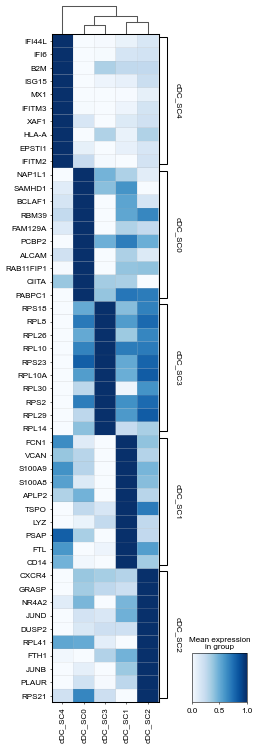

In [9]:
#Matrix Plot of Top 10 Genes per Cluster
matplotlib.style.use('default')
sc.settings.set_figure_params(dpi=50)  # set sufficiently high resolution for saving
axs = sc.pl.rank_genes_groups_matrixplot(cDCs, n_genes=10, standard_scale='var', cmap='Blues', figsize=(5,18),swap_axes=True)


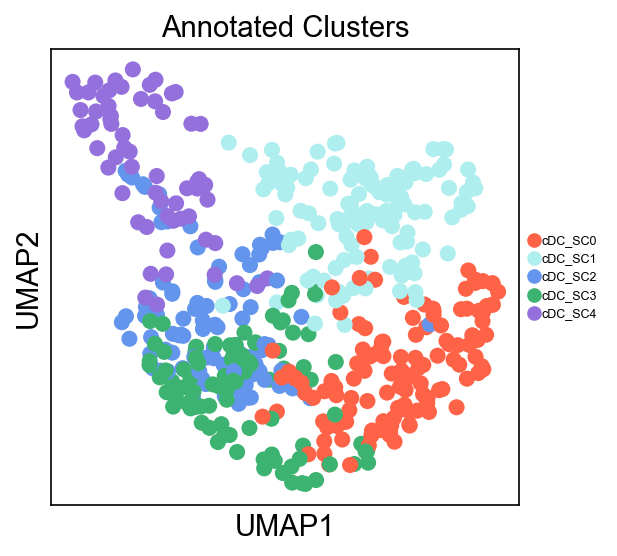

In [10]:
sc.set_figure_params(dpi=150)

#Plotting cDCs via UMAP
colors = ['tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8']
sc.pl.umap(cDCs, color=['SCs'],legend_loc='right margin',frameon=True, 
           title='Annotated Clusters',legend_fontsize=6,palette=colors, legend_fontoutline=1,add_outline=False,)


categories: cDC_SC0, cDC_SC1, cDC_SC2, etc.
var_group_labels: DC5-AXL, DC2 (CD1C+_A)-3(CD1C+_B), DC1 (CLEC9A), etc.


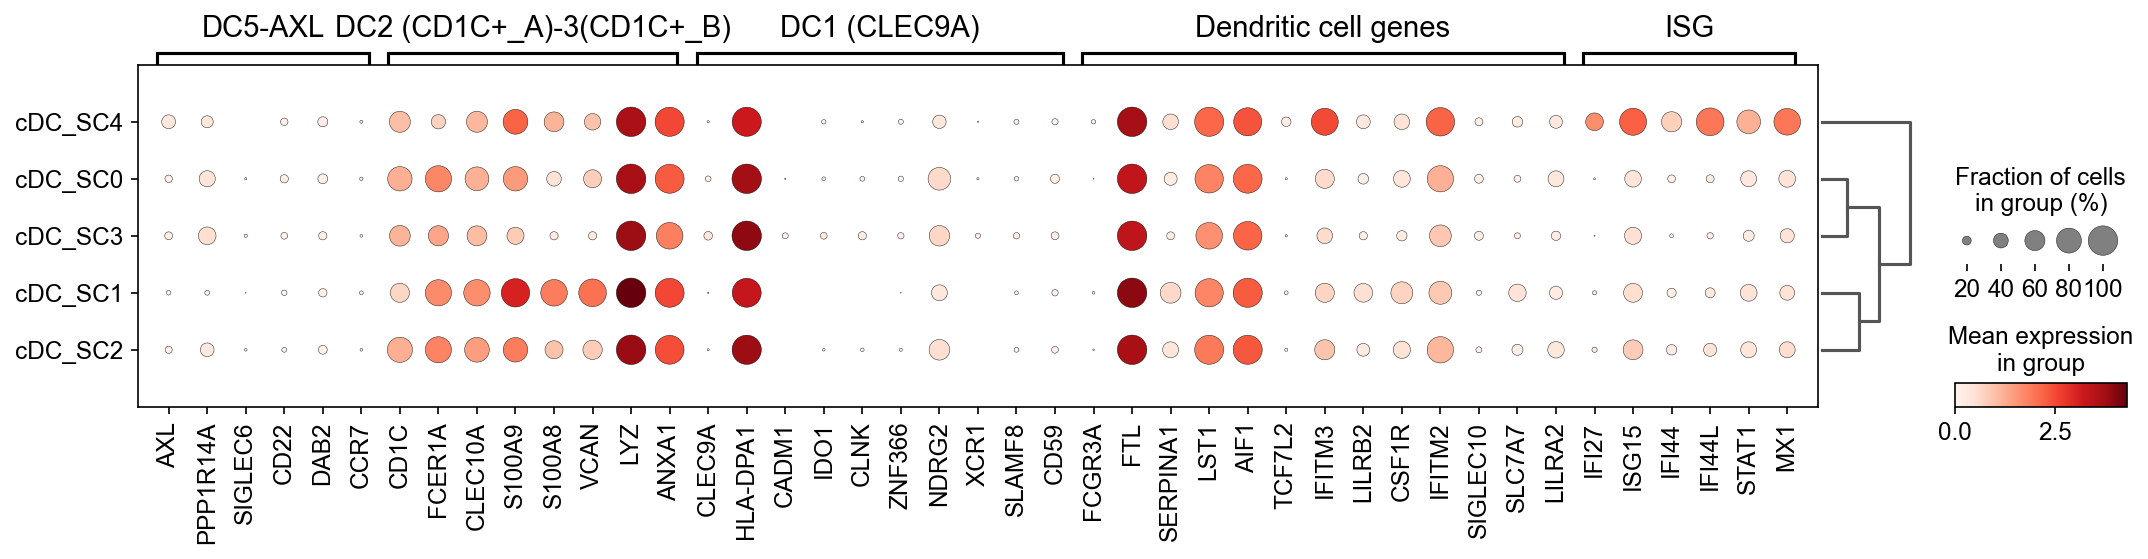

In [11]:
#Plotting a List of cDC Marker Genes
marker_genes_dict = {'DC5-AXL':['AXL', 'PPP1R14A', 'SIGLEC6', 'CD22', 'DAB2','CCR7'],
                     'DC2 (CD1C+_A)-3(CD1C+_B)':['CD1C', 'FCER1A', 'CLEC10A','S100A9', 'S100A8', 'VCAN', 'LYZ', 'ANXA1',], #DC2 (CD1C+_A)-3(CD1C+_B)
                     'DC1 (CLEC9A)':['CLEC9A', 'HLA-DPA1', 'CADM1', 'IDO1', 'CLNK','ZNF366', 'NDRG2', 'XCR1', 'SLAMF8', 'CD59',], #
                         'Dendritic cell genes':['FCGR3A', 'FTL', 'SERPINA1', 'LST1', 'AIF1', 'TCF7L2', 'IFITM3', 'LILRB2', 'CSF1R', 'IFITM2','SIGLEC10', 'SLC7A7', 'LILRA2'],
                         'ISG':['IFI27','ISG15','IFI44','IFI44L','STAT1','MX1'],}


matplotlib.style.use('default')
sc.set_figure_params(dpi=150)
gs = sc.pl.dotplot(cDCs,
                  marker_genes_dict,
                  groupby='SCs',
                  dendrogram=True,
                  figsize=(17,3),
                  var_group_rotation=0)

# Slingshot Trajectory

In [12]:
%%R -i cDCs

#Converting AnnData to SingleCellExperiment Object
print(cDCs)

/opt/anaconda3/envs/scanpy_R/lib/python3.6/site-packages/anndata2ri/py2r.py:38: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


class: SingleCellExperiment 
dim: 1362 504 
metadata(15): Groups_colors Patient_groups_colors ... umap
  dendrogram_SCs
assays(2): X scaled
rownames(1362): HES4 ISG15 ... DIP2A S100B
rowData names(9): gene_ids feature_types ... mean std
colnames(504): AAGAACACATTCTGTT-1 AGCCACGGTTTAGTCG-1 ...
  TATACCTAGAAGTCTA-40 TCCGAAAGTTCGATTG-40
colData names(40): Cells Samples ... cDC_Res0_8 cDC_Res1
reducedDimNames(2): PCA UMAP
altExpNames(0):


Running Slingshot

In [13]:
%%R 
print("0:")
adata_sling <- slingshot(cDCs, clusterLabels = 'SCs',start.clus='cDC_SC0', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling))

[1] "0:"
class: SlingshotDataSet 

 Samples Dimensions
     504          3

lineages: 2 
Lineage1: cDC_SC0  cDC_SC1  cDC_SC2  
Lineage2: cDC_SC0  cDC_SC3  cDC_SC4  

curves: 2 
Curve1: Length: 11.58	Samples: 330.48
Curve2: Length: 11.513	Samples: 287.19


In [14]:
%%R

cells <- cDCs$Cells
sling1 <- adata_sling$slingPseudotime_1
sling2 <- adata_sling$slingPseudotime_2


#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1,slingPseudotime_2 = sling2)
write.csv(df,'./cDCs_07292021/cDCs_df_0.csv')


In [15]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./cDCs_07292021/cDCs_df_0.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_0'] = col.mean(axis=1)

sling_df.head()

cDCs.obs['sling_avg_0'] = sling_df['sling_avg_0']
cDCs.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAGAACACATTCTGTT-1  AAGAACACATTCTGTT-1       1  JB19050  HPIR_021_1    pHC1   
AGCCACGGTTTAGTCG-1  AGCCACGGTTTAGTCG-1       1  JB19050  HPIR_021_1    pHC1   
CCACGTTCATGAAGCG-1  CCACGTTCATGAAGCG-1       1  JB19050  HPIR_021_1    pHC1   
GACCTTCTCCTTCAGC-1  GACCTTCTCCTTCAGC-1       1  JB19050  HPIR_021_1    pHC1   
TACCTGCAGGCCTTCG-1  TACCTGCAGGCCTTCG-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ...  \
AAGAACACATTCTGTT-1    pHC         W       2.17       B1  2020  ...   
AGCCACGGTTTAGTCG-1    pHC         W       2.17       B1  2020  ...   
CCACGTTCATGAAGCG-1    pHC         W       2.17       B1  2020  ...   
GACCTTCTCCTTCAGC-1    pHC         W       2.17       B1  2020  ...   
TACCTGCAGGCCTTCG-1    pHC         W       2.17       B1  2020  ...   

                   CXCL8_IFI27  CXCL8_ISG15 CXCL8_XAF1  Merged_SCs      SCs  \
AAGAACACATTCTGTT-1     Neither      Neither    Neither           6  cDC_SC2   
AGCCACGGTTTAGTCG-1     Neither      Neither    Neither           6  cDC_SC2   
CCACGTTCATGAAGCG-1     Neither      Neither    Neither           6  cDC_SC2   
GACCTTCTCCTTCAGC-1     Neither      Neither    Neither           6  cDC_SC2   
TACCTGCAGGCCTTCG-1     Neither      Neither    Neither           6  cDC_SC2   

                    cDC_Res0_4 cDC_Res0_6 cDC_Res0_8 cDC_Res1 sling_avg_0  
AAGAACACATTCTGTT-1           2          2          2        2    2.091629  
AGCCACGGTTTAGTCG-1           2          2          2        2    1.750647  
CCACGTTCATGAAGCG-1           2          2          2        2    2.252380  
GACCTTCTCCTTCAGC-1           2          2          2        2    1.882750  
TACCTGCAGGCCTTCG-1           2          2          2        2    0.839706  

[5 rows x 41 columns]

In [16]:
%%R 
print("1:")
adata_sling_1 <- slingshot(cDCs, clusterLabels = 'SCs',start.clus='cDC_SC1', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_1))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
     504          3

lineages: 2 
Lineage1: cDC_SC1  cDC_SC0  cDC_SC3  cDC_SC4  
Lineage2: cDC_SC1  cDC_SC2  

curves: 2 
Curve1: Length: 12.093	Samples: 361.53
Curve2: Length: 8.0696	Samples: 217.97


In [17]:
%%R

cells <- cDCs$Cells
sling1 <- adata_sling_1$slingPseudotime_1
sling2 <- adata_sling_1$slingPseudotime_2


#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1,slingPseudotime_2 = sling2)
write.csv(df,'./cDCs_07292021/cDCs_df_1.csv')


In [18]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./cDCs_07292021/cDCs_df_1.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_1'] = col.mean(axis=1)

sling_df.head()

cDCs.obs['sling_avg_1'] = sling_df['sling_avg_1']
cDCs.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAGAACACATTCTGTT-1  AAGAACACATTCTGTT-1       1  JB19050  HPIR_021_1    pHC1   
AGCCACGGTTTAGTCG-1  AGCCACGGTTTAGTCG-1       1  JB19050  HPIR_021_1    pHC1   
CCACGTTCATGAAGCG-1  CCACGTTCATGAAGCG-1       1  JB19050  HPIR_021_1    pHC1   
GACCTTCTCCTTCAGC-1  GACCTTCTCCTTCAGC-1       1  JB19050  HPIR_021_1    pHC1   
TACCTGCAGGCCTTCG-1  TACCTGCAGGCCTTCG-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ...  \
AAGAACACATTCTGTT-1    pHC         W       2.17       B1  2020  ...   
AGCCACGGTTTAGTCG-1    pHC         W       2.17       B1  2020  ...   
CCACGTTCATGAAGCG-1    pHC         W       2.17       B1  2020  ...   
GACCTTCTCCTTCAGC-1    pHC         W       2.17       B1  2020  ...   
TACCTGCAGGCCTTCG-1    pHC         W       2.17       B1  2020  ...   

                   CXCL8_ISG15  CXCL8_XAF1 Merged_SCs      SCs  cDC_Res0_4  \
AAGAACACATTCTGTT-1     Neither     Neither          6  cDC_SC2           2   
AGCCACGGTTTAGTCG-1     Neither     Neither          6  cDC_SC2           2   
CCACGTTCATGAAGCG-1     Neither     Neither          6  cDC_SC2           2   
GACCTTCTCCTTCAGC-1     Neither     Neither          6  cDC_SC2           2   
TACCTGCAGGCCTTCG-1     Neither     Neither          6  cDC_SC2           2   

                    cDC_Res0_6 cDC_Res0_8 cDC_Res1 sling_avg_0 sling_avg_1  
AAGAACACATTCTGTT-1           2          2        2    2.091629    7.196614  
AGCCACGGTTTAGTCG-1           2          2        2    1.750647    7.202329  
CCACGTTCATGAAGCG-1           2          2        2    2.252380    7.286101  
GACCTTCTCCTTCAGC-1           2          2        2    1.882750    7.237329  
TACCTGCAGGCCTTCG-1           2          2        2    0.839706    8.069643  

[5 rows x 42 columns]

In [19]:
%%R 
print("2:")
adata_sling_2 <- slingshot(cDCs, clusterLabels = 'SCs',start.clus='cDC_SC2', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_2))

[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
     504          3

lineages: 1 
Lineage1: cDC_SC2  cDC_SC1  cDC_SC0  cDC_SC3  cDC_SC4  

curves: 1 
Curve1: Length: 12.661	Samples: 504


In [20]:
%%R

cells <- cDCs$Cells
sling1 <- adata_sling_2$slingPseudotime_1


#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1)
write.csv(df,'./cDCs_07292021/cDCs_df_2.csv')


In [21]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./cDCs_07292021/cDCs_df_2.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_2'] = col.mean(axis=1)

sling_df.head()

cDCs.obs['sling_avg_2'] = sling_df['sling_avg_2']
cDCs.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAGAACACATTCTGTT-1  AAGAACACATTCTGTT-1       1  JB19050  HPIR_021_1    pHC1   
AGCCACGGTTTAGTCG-1  AGCCACGGTTTAGTCG-1       1  JB19050  HPIR_021_1    pHC1   
CCACGTTCATGAAGCG-1  CCACGTTCATGAAGCG-1       1  JB19050  HPIR_021_1    pHC1   
GACCTTCTCCTTCAGC-1  GACCTTCTCCTTCAGC-1       1  JB19050  HPIR_021_1    pHC1   
TACCTGCAGGCCTTCG-1  TACCTGCAGGCCTTCG-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ... CXCL8_XAF1  \
AAGAACACATTCTGTT-1    pHC         W       2.17       B1  2020  ...    Neither   
AGCCACGGTTTAGTCG-1    pHC         W       2.17       B1  2020  ...    Neither   
CCACGTTCATGAAGCG-1    pHC         W       2.17       B1  2020  ...    Neither   
GACCTTCTCCTTCAGC-1    pHC         W       2.17       B1  2020  ...    Neither   
TACCTGCAGGCCTTCG-1    pHC         W       2.17       B1  2020  ...    Neither   

                    Merged_SCs      SCs  cDC_Res0_4  cDC_Res0_6  cDC_Res0_8  \
AAGAACACATTCTGTT-1           6  cDC_SC2           2           2           2   
AGCCACGGTTTAGTCG-1           6  cDC_SC2           2           2           2   
CCACGTTCATGAAGCG-1           6  cDC_SC2           2           2           2   
GACCTTCTCCTTCAGC-1           6  cDC_SC2           2           2           2   
TACCTGCAGGCCTTCG-1           6  cDC_SC2           2           2           2   

                   cDC_Res1 sling_avg_0 sling_avg_1 sling_avg_2  
AAGAACACATTCTGTT-1        2    2.091629    7.196614    0.554873  
AGCCACGGTTTAGTCG-1        2    1.750647    7.202329    0.451184  
CCACGTTCATGAAGCG-1        2    2.252380    7.286101    1.121007  
GACCTTCTCCTTCAGC-1        2    1.882750    7.237329    0.663536  
TACCTGCAGGCCTTCG-1        2    0.839706    8.069643    0.325136  

[5 rows x 43 columns]

In [22]:
%%R 
print("3:")
adata_sling_3 <- slingshot(cDCs, clusterLabels = 'SCs',start.clus='cDC_SC3', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_3))

[1] "3:"
class: SlingshotDataSet 

 Samples Dimensions
     504          3

lineages: 2 
Lineage1: cDC_SC3  cDC_SC0  cDC_SC1  cDC_SC2  
Lineage2: cDC_SC3  cDC_SC4  

curves: 2 
Curve1: Length: 10.871	Samples: 428.05
Curve2: Length: 7.4854	Samples: 149.35


In [23]:
%%R

cells <- cDCs$Cells
sling1 <- adata_sling_3$slingPseudotime_1
sling2 <- adata_sling_3$slingPseudotime_2



#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1,slingPseudotime_2 = sling2)
write.csv(df,'./cDCs_07292021/cDCs_df_3.csv')


In [24]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./cDCs_07292021/cDCs_df_3.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_3'] = col.mean(axis=1)

sling_df.head()

cDCs.obs['sling_avg_3'] = sling_df['sling_avg_3']
cDCs.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAGAACACATTCTGTT-1  AAGAACACATTCTGTT-1       1  JB19050  HPIR_021_1    pHC1   
AGCCACGGTTTAGTCG-1  AGCCACGGTTTAGTCG-1       1  JB19050  HPIR_021_1    pHC1   
CCACGTTCATGAAGCG-1  CCACGTTCATGAAGCG-1       1  JB19050  HPIR_021_1    pHC1   
GACCTTCTCCTTCAGC-1  GACCTTCTCCTTCAGC-1       1  JB19050  HPIR_021_1    pHC1   
TACCTGCAGGCCTTCG-1  TACCTGCAGGCCTTCG-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ... Merged_SCs  \
AAGAACACATTCTGTT-1    pHC         W       2.17       B1  2020  ...          6   
AGCCACGGTTTAGTCG-1    pHC         W       2.17       B1  2020  ...          6   
CCACGTTCATGAAGCG-1    pHC         W       2.17       B1  2020  ...          6   
GACCTTCTCCTTCAGC-1    pHC         W       2.17       B1  2020  ...          6   
TACCTGCAGGCCTTCG-1    pHC         W       2.17       B1  2020  ...          6   

                        SCs cDC_Res0_4  cDC_Res0_6  cDC_Res0_8  cDC_Res1  \
AAGAACACATTCTGTT-1  cDC_SC2          2           2           2         2   
AGCCACGGTTTAGTCG-1  cDC_SC2          2           2           2         2   
CCACGTTCATGAAGCG-1  cDC_SC2          2           2           2         2   
GACCTTCTCCTTCAGC-1  cDC_SC2          2           2           2         2   
TACCTGCAGGCCTTCG-1  cDC_SC2          2           2           2         2   

                   sling_avg_0 sling_avg_1 sling_avg_2 sling_avg_3  
AAGAACACATTCTGTT-1    2.091629    7.196614    0.554873   10.687390  
AGCCACGGTTTAGTCG-1    1.750647    7.202329    0.451184   10.623560  
CCACGTTCATGAAGCG-1    2.252380    7.286101    1.121007   10.232223  
GACCTTCTCCTTCAGC-1    1.882750    7.237329    0.663536   10.489959  
TACCTGCAGGCCTTCG-1    0.839706    8.069643    0.325136   10.534852  

[5 rows x 44 columns]

In [25]:
%%R 
print("4:")
adata_sling_4 <- slingshot(cDCs, clusterLabels = 'SCs',start.clus='cDC_SC4', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_4))

[1] "4:"
class: SlingshotDataSet 

 Samples Dimensions
     504          3

lineages: 1 
Lineage1: cDC_SC4  cDC_SC3  cDC_SC0  cDC_SC1  cDC_SC2  

curves: 1 
Curve1: Length: 12.662	Samples: 504


In [26]:
%%R

cells <- cDCs$Cells
sling1 <- adata_sling_4$slingPseudotime_1



#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1)
write.csv(df,'./cDCs_07292021/cDCs_df_4.csv')


In [27]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./cDCs_07292021/cDCs_df_4.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_4'] = col.mean(axis=1)

sling_df.head()

cDCs.obs['sling_avg_4'] = sling_df['sling_avg_4']
cDCs.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAGAACACATTCTGTT-1  AAGAACACATTCTGTT-1       1  JB19050  HPIR_021_1    pHC1   
AGCCACGGTTTAGTCG-1  AGCCACGGTTTAGTCG-1       1  JB19050  HPIR_021_1    pHC1   
CCACGTTCATGAAGCG-1  CCACGTTCATGAAGCG-1       1  JB19050  HPIR_021_1    pHC1   
GACCTTCTCCTTCAGC-1  GACCTTCTCCTTCAGC-1       1  JB19050  HPIR_021_1    pHC1   
TACCTGCAGGCCTTCG-1  TACCTGCAGGCCTTCG-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ...      SCs  \
AAGAACACATTCTGTT-1    pHC         W       2.17       B1  2020  ...  cDC_SC2   
AGCCACGGTTTAGTCG-1    pHC         W       2.17       B1  2020  ...  cDC_SC2   
CCACGTTCATGAAGCG-1    pHC         W       2.17       B1  2020  ...  cDC_SC2   
GACCTTCTCCTTCAGC-1    pHC         W       2.17       B1  2020  ...  cDC_SC2   
TACCTGCAGGCCTTCG-1    pHC         W       2.17       B1  2020  ...  cDC_SC2   

                    cDC_Res0_4 cDC_Res0_6  cDC_Res0_8  cDC_Res1  sling_avg_0  \
AAGAACACATTCTGTT-1           2          2           2         2     2.091629   
AGCCACGGTTTAGTCG-1           2          2           2         2     1.750647   
CCACGTTCATGAAGCG-1           2          2           2         2     2.252380   
GACCTTCTCCTTCAGC-1           2          2           2         2     1.882750   
TACCTGCAGGCCTTCG-1           2          2           2         2     0.839706   

                   sling_avg_1 sling_avg_2 sling_avg_3 sling_avg_4  
AAGAACACATTCTGTT-1    7.196614    0.554873   10.687390   12.107397  
AGCCACGGTTTAGTCG-1    7.202329    0.451184   10.623560   12.211038  
CCACGTTCATGAAGCG-1    7.286101    1.121007   10.232223   11.541286  
GACCTTCTCCTTCAGC-1    7.237329    0.663536   10.489959   11.998705  
TACCTGCAGGCCTTCG-1    8.069643    0.325136   10.534852   12.337038  

[5 rows x 45 columns]

In [28]:
cDCs.write("./cDCs_07292021/cDCs_pCov_Trajectory.h5ad")

Plotting Slingshot Curves

In [29]:
%%R
col_Groups = c('pCov'="#9E9AC8",'pHC'="#66BD63")
col_pGroups = c('G1'="#D8DAEB", 'G2'="#9E9AC8", 'G3'="#54278F",'pHC'="#66BD63")

In [30]:
%%R
THEME <- theme(axis.text.y=element_text(size=16),
                    axis.text.x=element_text(size=16, angle = 90),
                    axis.title.x = element_text(face="bold", size=14),
                    axis.title.y = element_text(face="bold", size=14),
                    plot.title = element_text(hjust = 0.5,face='bold',size=14),
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_rect(fill='white', colour='white'),
                    panel.border = element_rect(fill=NA, color = 'black', size=1),
                    legend.direction = "horizontal", legend.position = 'bottom', legend.text.align = 1,
                    legend.text = element_text(size=9),
                    legend.key.size = unit(0.4, "cm"),
                    legend.key.width = unit(0.4,"cm"))

In [31]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('paleturquoise','tomato', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

Start Clus: 0

In [32]:
%%R 
#Plotting Slingshot lineages and curves


pdf(file="./cDCs_07292021/Figures/sling0_cDCs_Lin.pdf")
#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colors[cut(adata_sling$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colors[cut(adata_sling$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling)$curve2, lwd=2)

#Plot of lineage 3
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colors[cut(adata_sling$slingPseudotime_3,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling)$curve3, lwd=2)

#Plot of lineage 4
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colors[cut(adata_sling$slingPseudotime_4,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling)$curve4, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling)$UMAP, col = colour_map[cDCs$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling)$curve1,lwd=2) + lines(slingCurves(adata_sling)$curve2,lwd=2) + lines(slingCurves(adata_sling)$curve3,lwd=2)+ lines(slingCurves(adata_sling)$curve4,lwd=2) + lines(slingCurves(adata_sling)$curve5,lwd=2)+lines(slingCurves(adata_sling)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(cDCs)$cDCscells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colour_map[cDCs$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling), lwd=2, type='lineages')

/opt/anaconda3/envs/scanpy_R/lib/python3.6/site-packages/anndata2ri/py2r.py:38: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


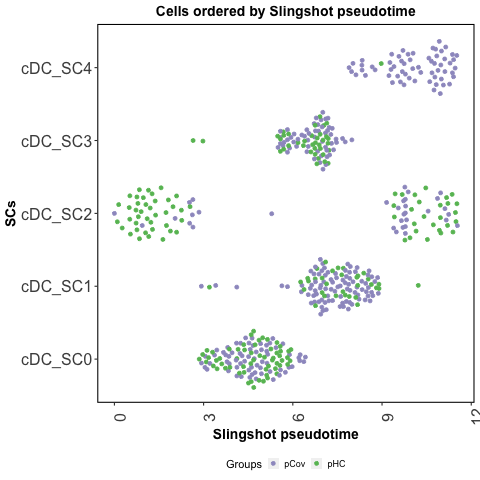

In [33]:
%%R -i cDCs
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_0, y = SCs, colour = Groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_Groups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


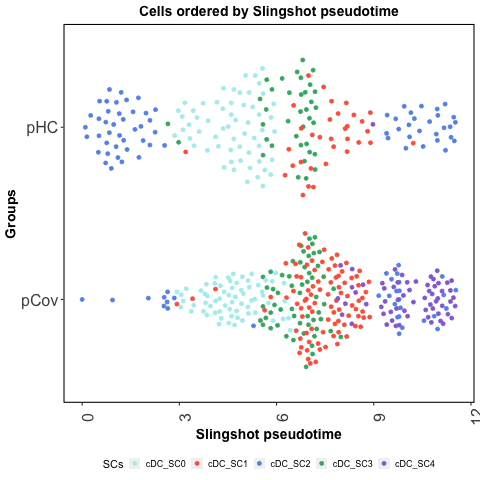

In [34]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_0, y = Groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


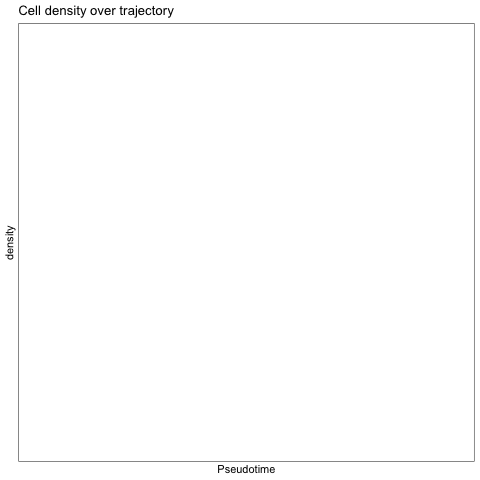

In [35]:
%%R
#Histogram of Trajectory
pt1 <- cDCs$sling_avg_0
clustDat <- cDCs$SCs
groups1 <- cDCs$Groups


#Subset data to only include cells on lineage 1
#cells <- cells[!is.na(pt1)]
#clustDat <- clustDat[!is.na(pt1)]
#pt1 <- pt1[!is.na(pt1)]
#groups1 <- groups[!(pt1)]
df = data.frame(clusters = clustDat, pt = pt1, groups=groups1)

bin_width = 0.80
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

dominant_groups = sapply(levels(df$bins), function(x){Mode(df$groups[df$bins==x])})
levels(dominant_groups) <- c(levels(dominant_groups), 'None')
dominant_groups[is.na(dominant_groups)] <- 'None'


cmap <- colour_map
cmap2 <- col_Groups

p <- ggplot() +
  geom_histogram( aes(x = cDCs$sling_avg, y = ..density..), binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
  #geom_label( aes(x=4.5, y=0.25, label="variable1"), color="#69b3a2") +
  geom_histogram( aes(x = cDCs$sling_avg, y = -..density..), binwidth=bin_width, fill=I(col_Groups[dominant_groups])) +
  #geom_label( aes(x=4.5, y=-0.25, label="variable2"), color="#404080") +
  theme_bw() + ggtitle('Cell density over trajectory')+
  xlab("Pseudotime") 
print(p)

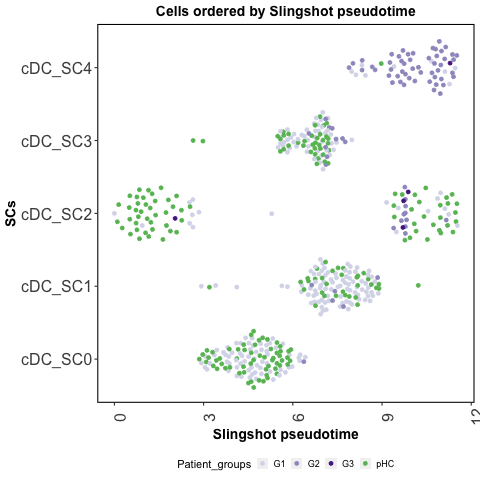

In [36]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_0, y = SCs, colour = Patient_groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")
#ggsave("./cDCs_07292021/Figures/sling0_cDCs_violin_pGroups.pdf", dpi=72)

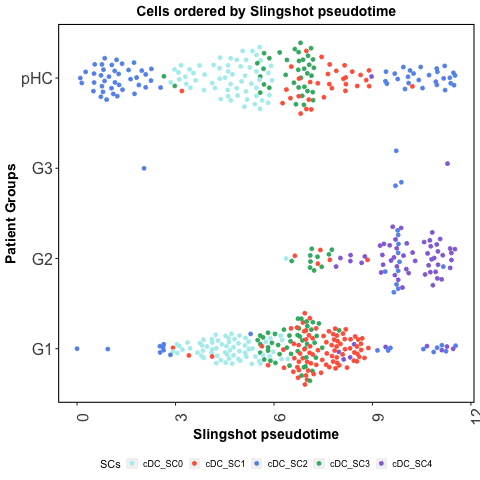

In [37]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_0, y = Patient_groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime")+ ylab("Patient Groups") + ggtitle("Cells ordered by Slingshot pseudotime")


Start Clus: 1

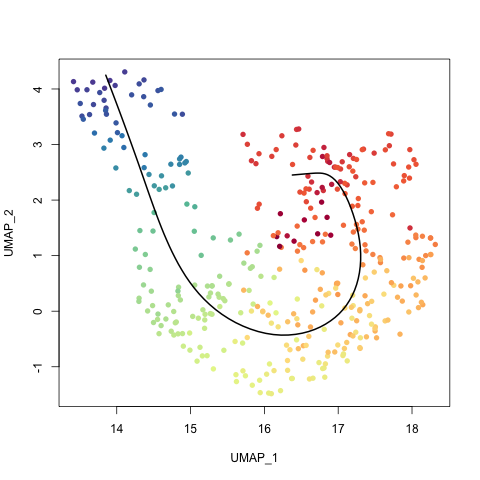

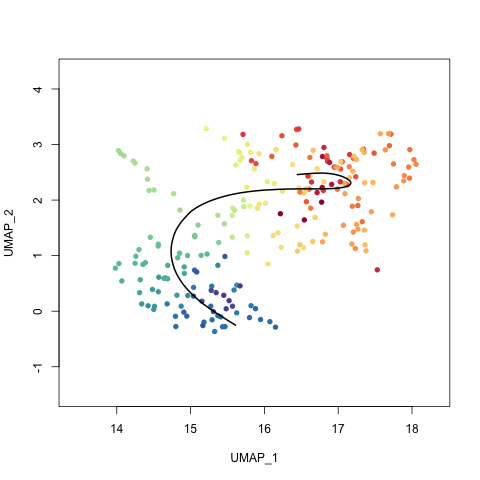

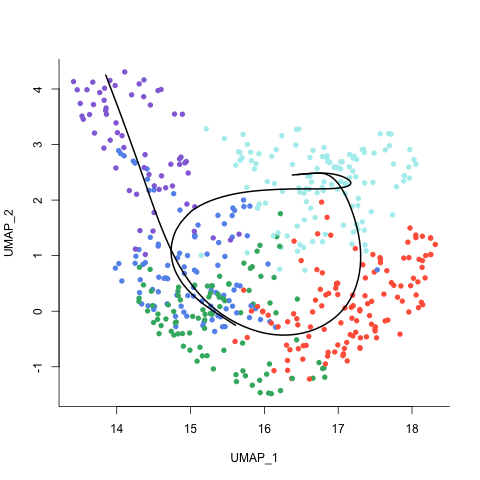

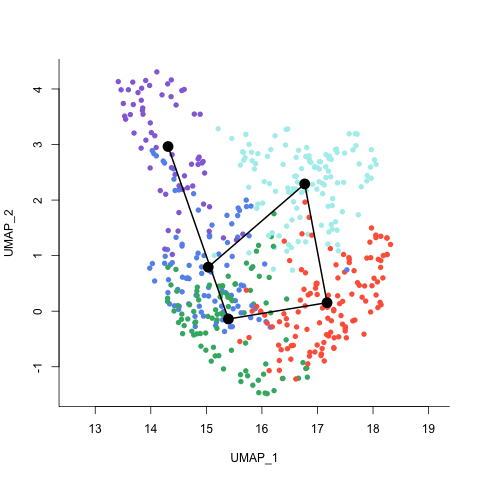

In [38]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colors[cut(adata_sling_1$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_1)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colors[cut(adata_sling_1$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_1)$curve2, lwd=2)

#Plot of lineage 3
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colors[cut(adata_sling_1$slingPseudotime_3,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_1)$curve3, lwd=2)

#Plot of lineage 4
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colors[cut(adata_sling_1$slingPseudotime_4,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_1)$curve4, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_1)$UMAP, col = colour_map[cDCs$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_1)$curve1,lwd=2) + lines(slingCurves(adata_sling_1)$curve2,lwd=2) + lines(slingCurves(adata_sling_1)$curve3,lwd=2)+ lines(slingCurves(adata_sling_1)$curve4,lwd=2) + lines(slingCurves(adata_sling_1)$curve5,lwd=2)+lines(slingCurves(adata_sling_1)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(cDCs)$cDCscells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colour_map[cDCs$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_1), lwd=2, type='lineages')

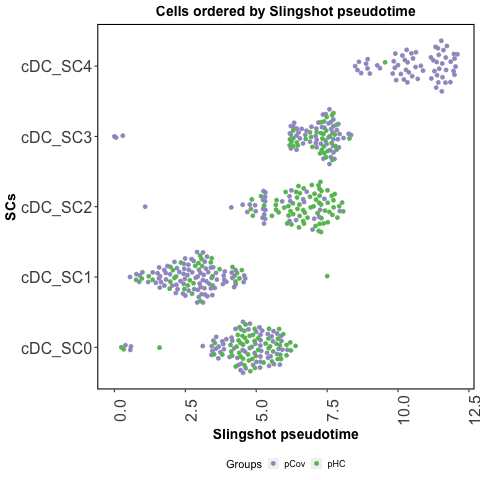

In [39]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_1, y = SCs, colour = Groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_Groups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


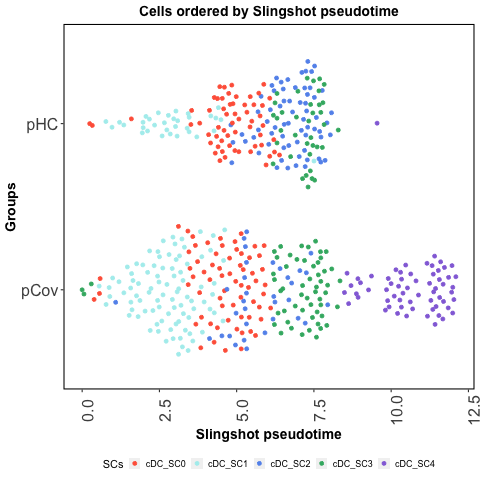

In [40]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_1, y = Groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


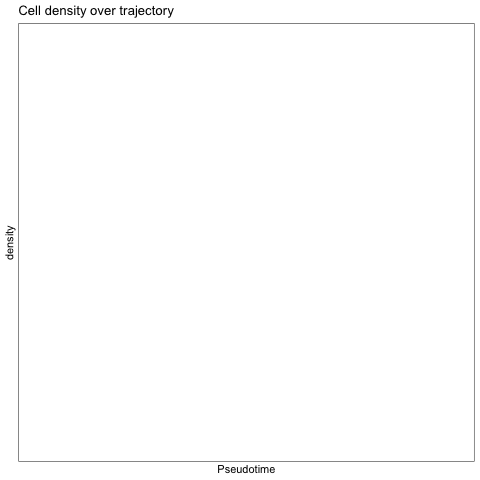

In [41]:
%%R
#Histogram of Trajectory
pt1 <- cDCs$sling_avg_1
clustDat <- cDCs$SCs
groups1 <- cDCs$Groups


#Subset data to only include cells on lineage 1
#cells <- cells[!is.na(pt1)]
#clustDat <- clustDat[!is.na(pt1)]
#pt1 <- pt1[!is.na(pt1)]
#groups1 <- groups[!(pt1)]
df = data.frame(clusters = clustDat, pt = pt1, groups=groups1)

bin_width = 0.95
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

dominant_groups = sapply(levels(df$bins), function(x){Mode(df$groups[df$bins==x])})
levels(dominant_groups) <- c(levels(dominant_groups), 'None')
dominant_groups[is.na(dominant_groups)] <- 'None'


cmap <- colour_map
cmap2 <- col_Groups

p <- ggplot() +
  geom_histogram( aes(x = cDCs$sling_avg, y = ..density..), binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
  #geom_label( aes(x=4.5, y=0.25, label="variable1"), color="#69b3a2") +
  geom_histogram( aes(x = cDCs$sling_avg, y = -..density..), binwidth=bin_width, fill=I(col_Groups[dominant_groups])) +
  #geom_label( aes(x=4.5, y=-0.25, label="variable2"), color="#404080") +
  theme_bw() + ggtitle('Cell density over trajectory')+
  xlab("Pseudotime") 
print(p)

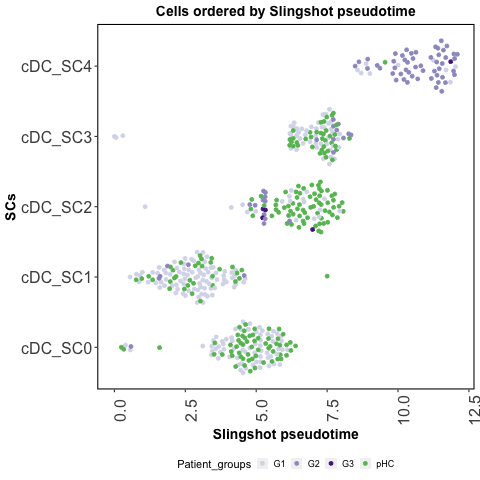

In [42]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_1, y = SCs, colour = Patient_groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


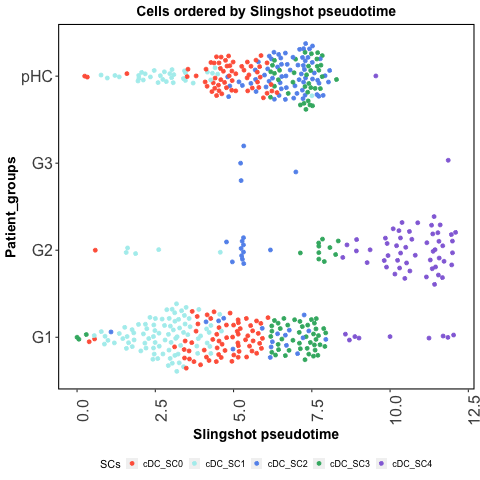

In [43]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_1, y = Patient_groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


Start Clus: 2

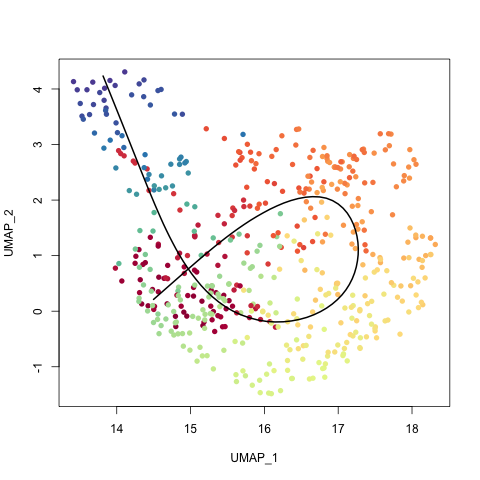

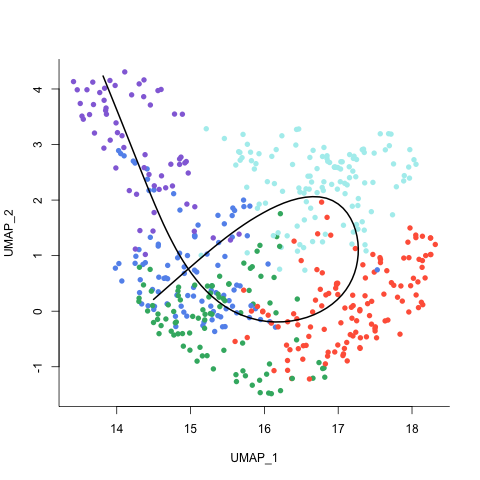

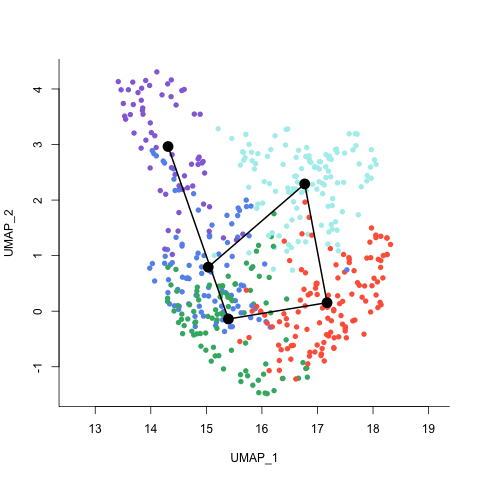

In [44]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colors[cut(adata_sling_2$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_2)$curve1, lwd=2)

#Plot of lineage 2
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colors[cut(adata_sling_2$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_2)$curve2, lwd=2)

#Plot of lineage 3
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colors[cut(adata_sling_2$slingPseudotime_3,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_2)$curve3, lwd=2)

#Plot of lineage 4
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colors[cut(adata_sling_2$slingPseudotime_4,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_2)$curve4, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_2)$UMAP, col = colour_map[cDCs$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_2)$curve1,lwd=2) + lines(slingCurves(adata_sling_2)$curve2,lwd=2) + lines(slingCurves(adata_sling_2)$curve3,lwd=2)+ lines(slingCurves(adata_sling_2)$curve4,lwd=2) + lines(slingCurves(adata_sling_2)$curve5,lwd=2)+lines(slingCurves(adata_sling_2)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(cDCs)$cDCscells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colour_map[cDCs$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_2), lwd=2, type='lineages')

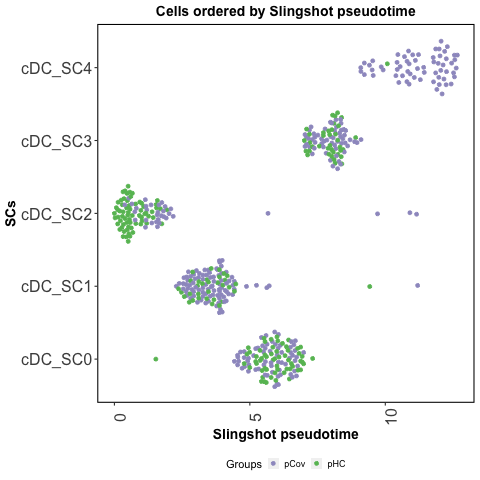

In [45]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_2, y = SCs, colour = Groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_Groups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


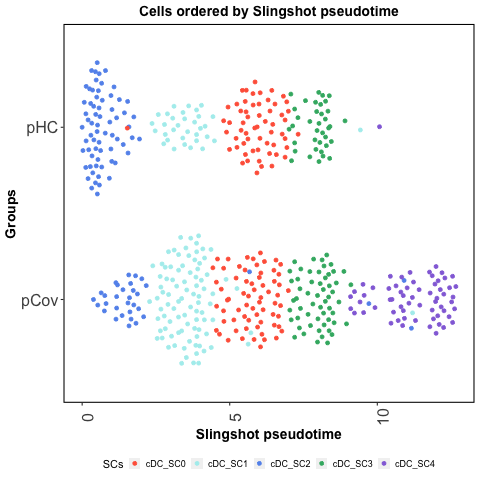

In [46]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_2, y = Groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


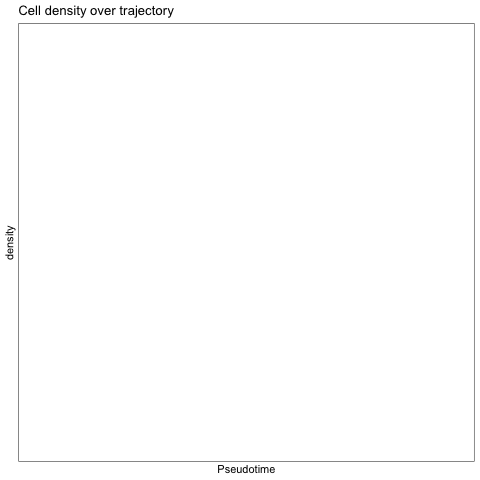

In [47]:
%%R
#Histogram of Trajectory
pt1 <- cDCs$sling_avg_2
clustDat <- cDCs$SCs
groups1 <- cDCs$Groups


#Subset data to only include cells on lineage 1
#cells <- cells[!is.na(pt1)]
#clustDat <- clustDat[!is.na(pt1)]
#pt1 <- pt1[!is.na(pt1)]
#groups1 <- groups[!(pt1)]
df = data.frame(clusters = clustDat, pt = pt1, groups=groups1)

bin_width = 0.95
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

dominant_groups = sapply(levels(df$bins), function(x){Mode(df$groups[df$bins==x])})
levels(dominant_groups) <- c(levels(dominant_groups), 'None')
dominant_groups[is.na(dominant_groups)] <- 'None'


cmap <- colour_map
cmap2 <- col_Groups

p <- ggplot() +
  geom_histogram( aes(x = cDCs$sling_avg, y = ..density..), binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
  #geom_label( aes(x=4.5, y=0.25, label="variable1"), color="#69b3a2") +
  geom_histogram( aes(x = cDCs$sling_avg, y = -..density..), binwidth=bin_width, fill=I(col_Groups[dominant_groups])) +
  #geom_label( aes(x=4.5, y=-0.25, label="variable2"), color="#404080") +
  theme_bw() + ggtitle('Cell density over trajectory')+
  xlab("Pseudotime") 
print(p)

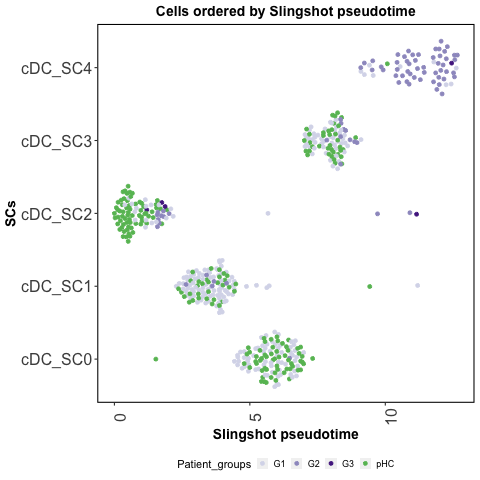

In [48]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_2, y = SCs, colour = Patient_groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


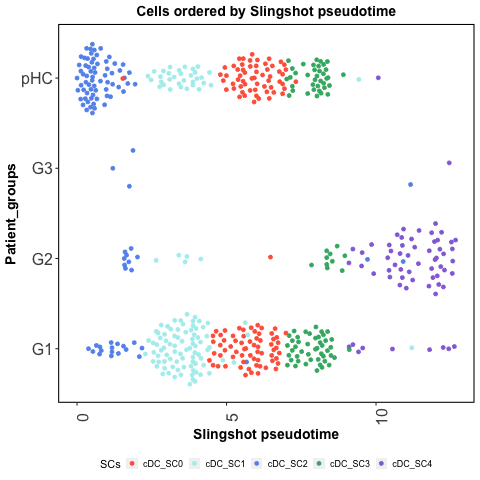

In [49]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_2, y = Patient_groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


Start Clus: 3

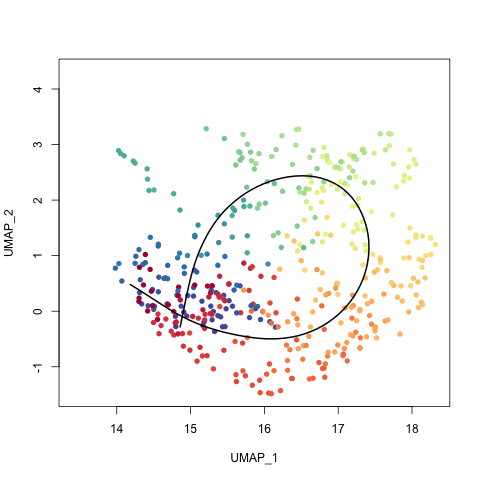

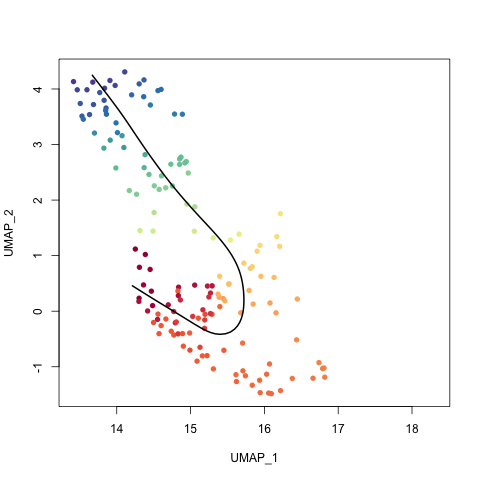

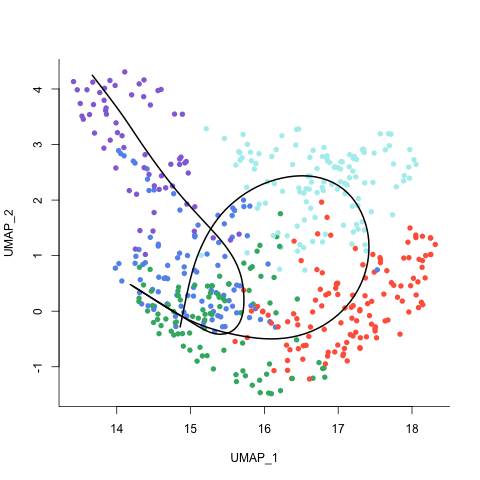

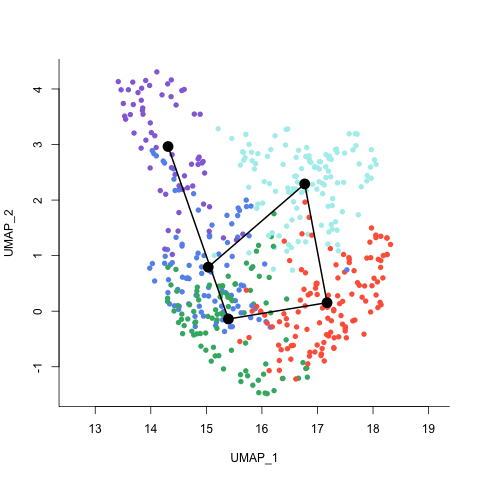

In [50]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colors[cut(adata_sling_3$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_3)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colors[cut(adata_sling_3$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_3)$curve2, lwd=2)

#Plot of lineage 3
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colors[cut(adata_sling_3$slingPseudotime_3,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_3)$curve3, lwd=2)

#Plot of lineage 4
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colors[cut(adata_sling_3$slingPseudotime_4,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_3)$curve4, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_3)$UMAP, col = colour_map[cDCs$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_3)$curve1,lwd=2) + lines(slingCurves(adata_sling_3)$curve2,lwd=2) + lines(slingCurves(adata_sling_3)$curve3,lwd=2)+ lines(slingCurves(adata_sling_3)$curve4,lwd=2) + lines(slingCurves(adata_sling_3)$curve5,lwd=2)+lines(slingCurves(adata_sling_3)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(cDCs)$cDCscells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colour_map[cDCs$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_3), lwd=2, type='lineages')

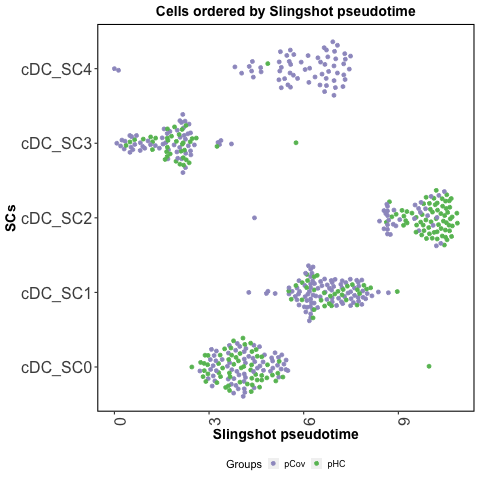

In [51]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_3, y = SCs, colour = Groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_Groups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


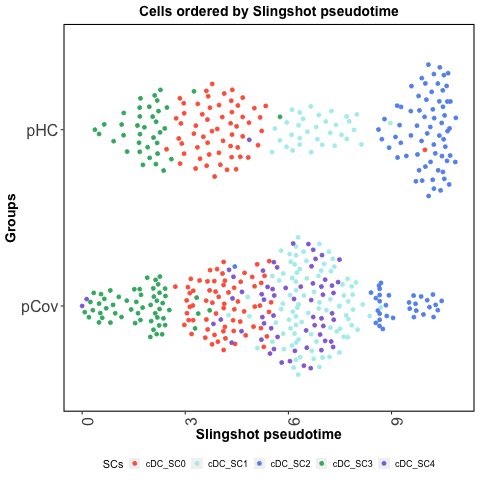

In [52]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_3, y = Groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


In [53]:
%%R
#Histogram of Trajectory
pt1 <- cDCs$sling_avg_3
clustDat <- cDCs$SCs
groups1 <- cDCs$Groups


#Subset data to only include cells on lineage 1
#cells <- cells[!is.na(pt1)]
#clustDat <- clustDat[!is.na(pt1)]
#pt1 <- pt1[!is.na(pt1)]
#groups1 <- groups[!(pt1)]
df = data.frame(clusters = clustDat, pt = pt1, groups=groups1)

bin_width = 0.95
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

dominant_groups = sapply(levels(df$bins), function(x){Mode(df$groups[df$bins==x])})
levels(dominant_groups) <- c(levels(dominant_groups), 'None')
dominant_groups[is.na(dominant_groups)] <- 'None'


cmap <- colour_map
cmap2 <- col_Groups
pdf(file="./cDCs_07292021/Figures/sling3_histo.pdf")

p <- ggplot() +
  geom_histogram( aes(x = cDCs$sling_avg, y = ..density..), binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
  #geom_label( aes(x=4.5, y=0.25, label="variable1"), color="#69b3a2") +
  geom_histogram( aes(x = cDCs$sling_avg, y = -..density..), binwidth=bin_width, fill=I(col_Groups[dominant_groups])) +
  #geom_label( aes(x=4.5, y=-0.25, label="variable2"), color="#404080") +
  theme_bw() + ggtitle('Cell density over trajectory')+
  xlab("Pseudotime") 
print(p)

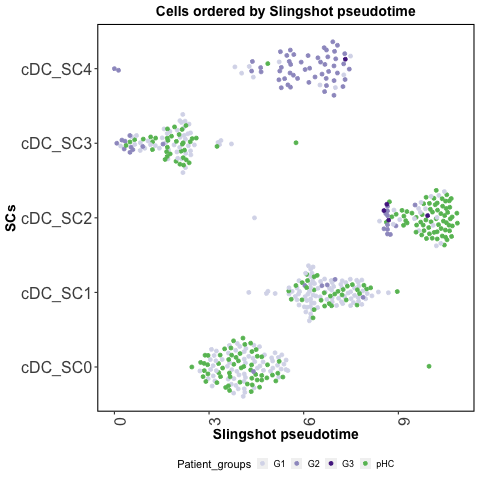

In [54]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_3, y = SCs, colour = Patient_groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


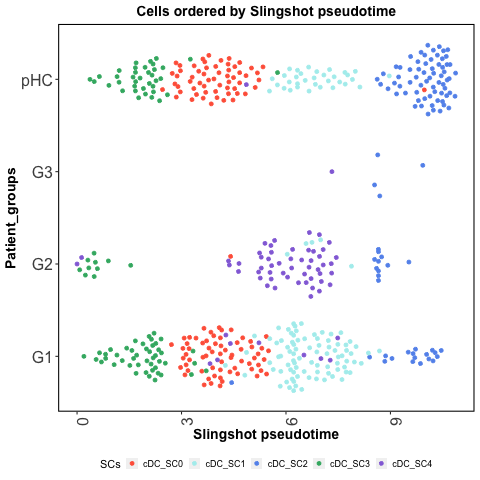

In [55]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_3, y = Patient_groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


Start Clus: 4

In [56]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

pdf(file="./cDCs_07292021/Figures/sling4_cDCs_Lin.pdf")
#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colors[cut(adata_sling_4$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_4)$curve1, lwd=2)

#Plot of lineage 2
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colors[cut(adata_sling_4$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_4)$curve2, lwd=2)

#Plot of lineage 3
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colors[cut(adata_sling_4$slingPseudotime_3,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_4)$curve3, lwd=2)

#Plot of lineage 4
#colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
#plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colors[cut(adata_sling_4$slingPseudotime_4,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
#lines(slingCurves(adata_sling_4)$curve4, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_4)$UMAP, col = colour_map[cDCs$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_4)$curve1,lwd=2) + lines(slingCurves(adata_sling_4)$curve2,lwd=2) + lines(slingCurves(adata_sling_4)$curve3,lwd=2)+ lines(slingCurves(adata_sling_4)$curve4,lwd=2) + lines(slingCurves(adata_sling_4)$curve5,lwd=2)+lines(slingCurves(adata_sling_4)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(cDCs)$cDCscells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colour_map[cDCs$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_4), lwd=2, type='lineages')

In [57]:
%%R 
#Violin Plots of Clusters across Groups
pdf(file="./cDCs_07292021/Figures/sling4_cDCs_violin_groups.pdf")
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_4, y = SCs, colour = Groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_Groups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


In [58]:
%%R 
#Violin Plots of Groups across Clusters
pdf(file="./cDCs_07292021/Figures/sling4_cDCs_violin_clusters.pdf")
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_4, y = Groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


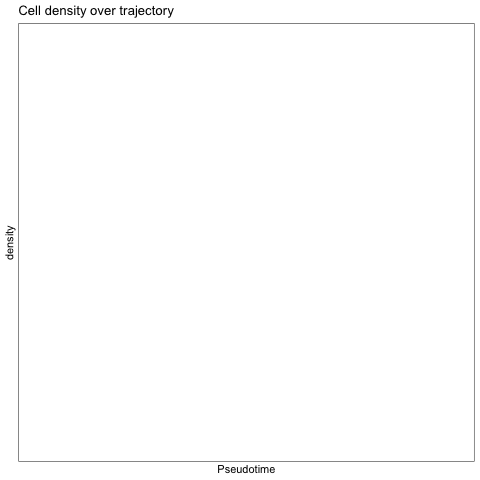

In [59]:
%%R
#Histogram of Trajectory
pt1 <- cDCs$sling_avg_4
clustDat <- cDCs$SCs
groups1 <- cDCs$Groups


#Subset data to only include cells on lineage 1
#cells <- cells[!is.na(pt1)]
#clustDat <- clustDat[!is.na(pt1)]
#pt1 <- pt1[!is.na(pt1)]
#groups1 <- groups[!(pt1)]
df = data.frame(clusters = clustDat, pt = pt1, groups=groups1)

bin_width = 0.95
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

dominant_groups = sapply(levels(df$bins), function(x){Mode(df$groups[df$bins==x])})
levels(dominant_groups) <- c(levels(dominant_groups), 'None')
dominant_groups[is.na(dominant_groups)] <- 'None'


cmap <- colour_map
cmap2 <- col_Groups

p <- ggplot() +
  geom_histogram( aes(x = cDCs$sling_avg, y = ..density..), binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
  #geom_label( aes(x=4.5, y=0.25, label="variable1"), color="#69b3a2") +
  geom_histogram( aes(x = cDCs$sling_avg, y = -..density..), binwidth=bin_width, fill=I(col_Groups[dominant_groups])) +
  #geom_label( aes(x=4.5, y=-0.25, label="variable2"), color="#404080") +
  theme_bw() + ggtitle('Cell density over trajectory')+
  xlab("Pseudotime") 
print(p)

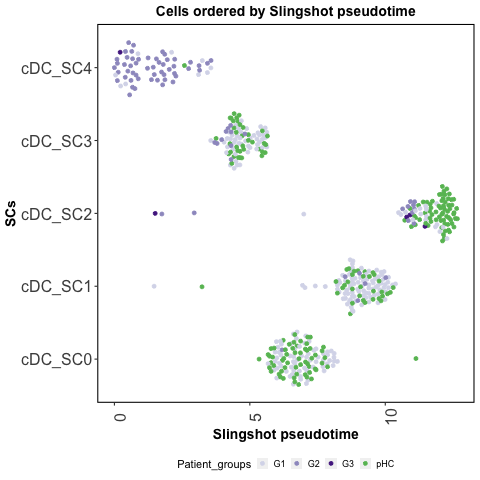

In [60]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_4, y = SCs, colour = Patient_groups)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


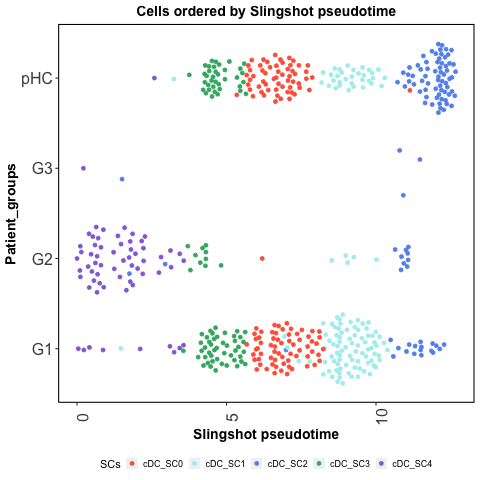

In [61]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(cDCs)), aes(x = sling_avg_4, y = Patient_groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 1.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


# Plotting Gene Scatterplots

In [62]:
cDCs

AnnData object with n_obs × n_vars = 504 × 1362
    obs: 'Cells', 'Samples', 'IDs', 'Names', 'Fig_ids', 'Groups', 'Ethnicity', 'Age_Months', 'runs_10X', 'Year', 'Patient_groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'Res1_2_BC', 'Res1_2_AC', 'Fig_ids_Groups', 'annotated_clusters', 'ISG_score_raw', 'ISG_score', 'INFLAM_score_raw', 'INFLAM_score', 'CD14_mono_Res1', 'CD14_mono_Res0_8', 'CD14_mono_Res0_6', 'CD14_mono_Res0_4', 'IL1B_IFI27', 'IL1B_ISG15', 'IL1B_XAF1', 'CXCL8_IFI27', 'CXCL8_ISG15', 'CXCL8_XAF1', 'Merged_SCs', 'SCs', 'cDC_Res0_4', 'cDC_Res0_6', 'cDC_Res0_8', 'cDC_Res1', 'sling_avg_0', 'sling_avg_1', 'sling_avg_2', 'sling_avg_3', 'sling_avg_4'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Groups_colors', 'Patient_groups_colors', 'SCs_colors', 'cDC_Res0_4_colors', 'cDC_Res0_6_colors', 'cDC_Res0_8_colors', 'cDC_Res1_colors', "dendrogram_['CD14_mono_

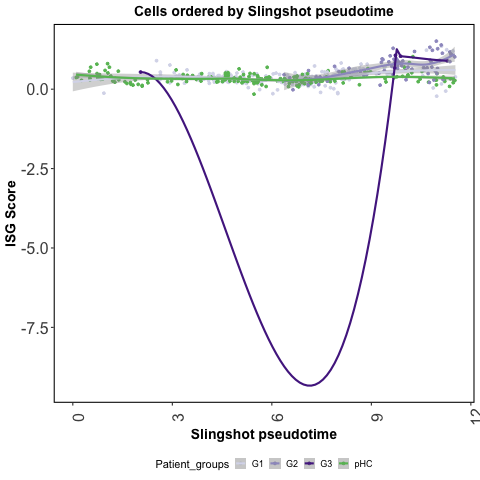

In [63]:
%%R -i cDCs
ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$ISG_score, colour = Patient_groups)) + geom_point(size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ylab("ISG Score") + ggtitle("Cells ordered by Slingshot pseudotime") + geom_smooth(aes(shape = NULL), method = "loess")



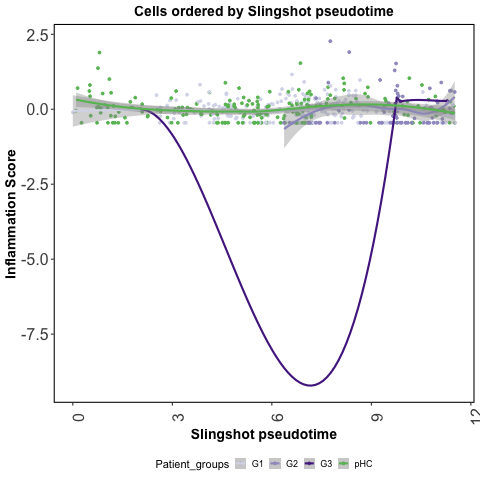

In [64]:
%%R
ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$INFLAM_score, colour = Patient_groups)) + geom_point(size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ylab("Inflammation Score") + ggtitle("Cells ordered by Slingshot pseudotime") + geom_smooth(aes(shape = NULL), method = "loess")

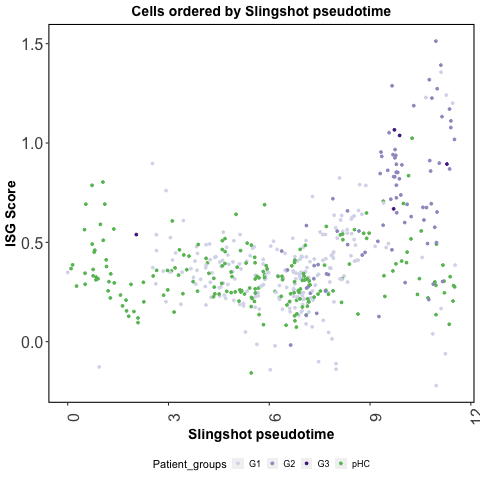

In [65]:
%%R

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$ISG_score, colour = Patient_groups)) + geom_point(size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ylab("ISG Score") + ggtitle("Cells ordered by Slingshot pseudotime") 



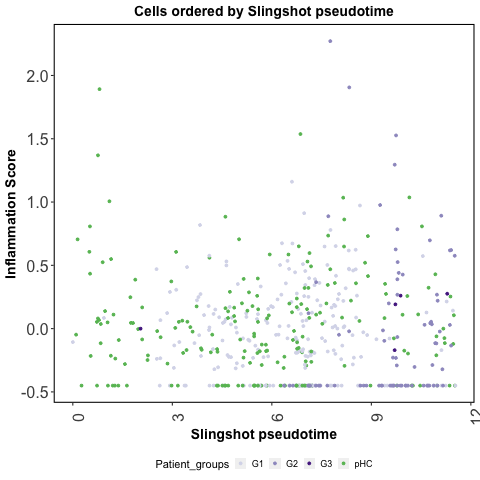

In [66]:
%%R

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$INFLAM_score, colour = Patient_groups)) + geom_point(size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ylab("Inflammation Score") + ggtitle("Cells ordered by Slingshot pseudotime")

In [67]:
cDCs.obs['CXCL8_ISG15'].value_counts(sort=False)


CXCL8           86
CXCL8_ISG15     12
ISG15           48
Neither        358
Name: CXCL8_ISG15, dtype: int64

In [68]:
cDCs.obs['IL1B_IFI27'] = cDCs.obs['IL1B_IFI27'].cat.reorder_categories(['Neither','IL1B','IFI27','IL1B_IFI27'])
cDCs.obs['IL1B_ISG15'] = cDCs.obs['IL1B_ISG15'].cat.reorder_categories(['Neither','IL1B','ISG15','IL1B_ISG15'])
cDCs.obs['IL1B_XAF1'] = cDCs.obs['IL1B_XAF1'].cat.reorder_categories(['Neither','IL1B','XAF1','IL1B_XAF1'])
cDCs.obs['CXCL8_IFI27'] = cDCs.obs['CXCL8_IFI27'].cat.reorder_categories(['Neither','CXCL8','IFI27','CXCL8_IFI27'])
cDCs.obs['CXCL8_ISG15'] = cDCs.obs['CXCL8_ISG15'].cat.reorder_categories(['Neither','CXCL8','ISG15','CXCL8_ISG15'])
cDCs.obs['CXCL8_XAF1'] = cDCs.obs['CXCL8_XAF1'].cat.reorder_categories(['Neither','CXCL8','XAF1','CXCL8_XAF1'])


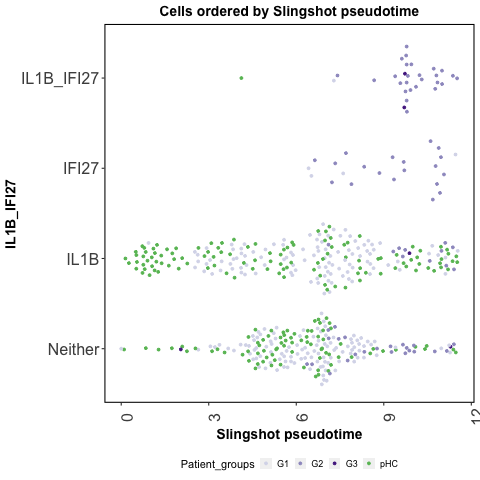

In [69]:
%%R -i cDCs

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$IL1B_IFI27, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("IL1B_IFI27")

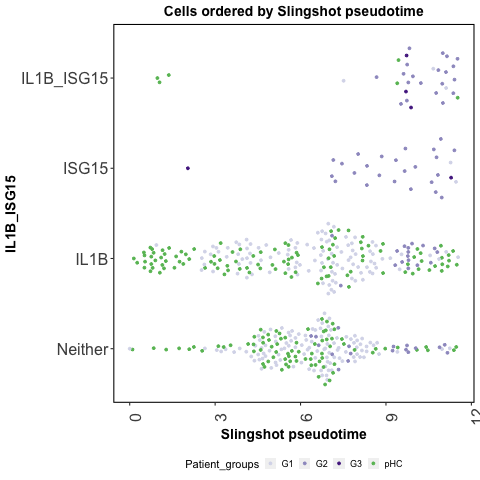

In [70]:
%%R

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$IL1B_ISG15, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("IL1B_ISG15")

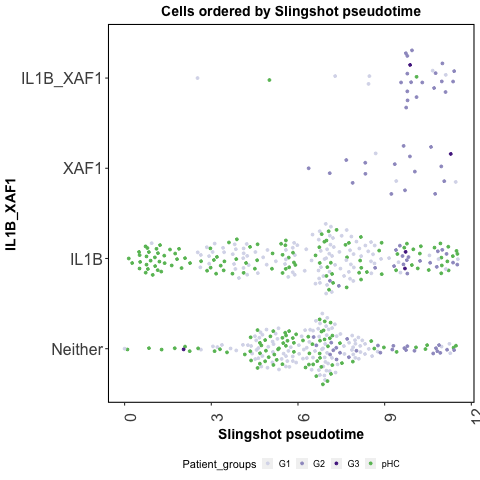

In [71]:
%%R

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$IL1B_XAF1, colour = Patient_groups)) + geom_quasirandom(groupOnX = FALSE,size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("IL1B_XAF1")


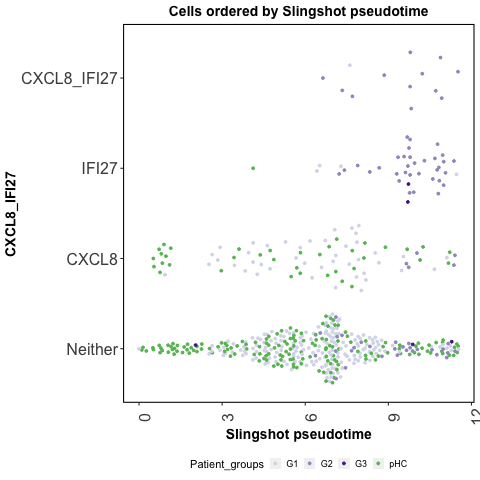

In [72]:
%%R

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$CXCL8_IFI27, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("CXCL8_IFI27")

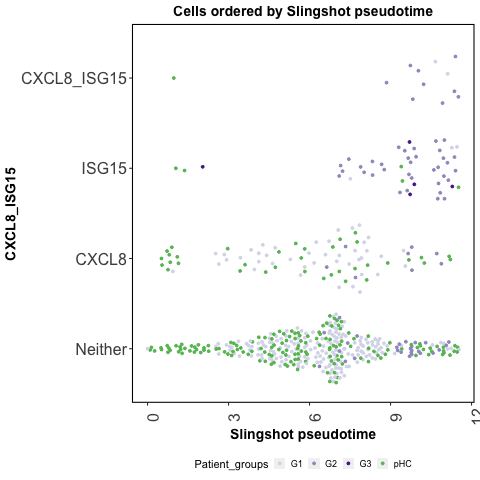

In [73]:
%%R

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$CXCL8_ISG15, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("CXCL8_ISG15")

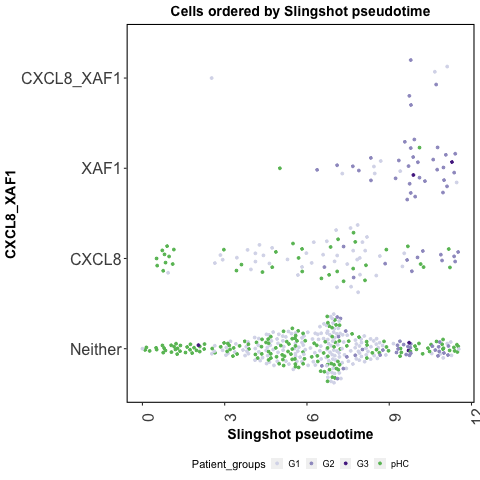

In [74]:
%%R

ggplot(as.data.frame(colData(cDCs)), aes(x=cDCs$sling_avg_0, y=cDCs$CXCL8_XAF1, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("CXCL8_XAF1")

# Plotting Gene Expression Heatmap

In [75]:
%%R -i cDCs

#Set the pseudotime variable
sling_values = data.frame(slingPseudotime_0 = cDCs$sling_avg_0)
t <- sling_values[ , c("slingPseudotime_0")]

#Extract the gene expression matrix
Y <- assay(cDCs)

# fit a GAM with a loess term for pseudotime
#Note: This takes a while
gam.pval <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})

In [76]:
%%R
#Select the top 100 most significant genes that change over pseudotime
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]
heatdata <- assay(cDCs)[rownames(assay(cDCs)) %in% topgenes, 
                        order(t, na.last = NA)]
write.csv(heatdata,'./cDCs_07292021/heatdata.csv')



In [77]:
heatdata = pd.read_csv('./cDCs_07292021/heatdata.csv')

heatdata = heatdata.set_index('Unnamed: 0')

heatdata = heatdata.rename_axis(None)

heatdata

GTGGGAACAGTAGTTC-11  TCACGGGTCGCTTGCT-3  AATCACGGTTGCCGCA-17  \
ISG15               -0.316861           -0.917454            -0.445678   
C1QA                -0.064776           -0.064776            -0.064776   
IFI6                -0.640703            0.097036            -0.640703   
NEXN                -0.179170           -0.179170            -0.179170   
IFI44L              -0.693029           -0.693029            -0.693029   
...                       ...                 ...                  ...   
MAFF                -0.214994           -0.214994             1.631012   
APOBEC3A            -0.263097           -0.263097            -0.263097   
TYMP                 2.088993            0.976809             2.408706   
MX2                 -0.574752           -0.574752             0.697837   
MX1                 -0.694645           -0.694645            -0.694645   

          GGTGTCGTCACCGGGT-17  TGCGGCACAGAAATTG-7  CAGCAATGTTACCCTC-6  \
ISG15               -0.917454            0.878968           -0.459321   
C1QA                -0.064776           -0.064776           -0.064776   
IFI6                -0.640703            0.015273           -0.640703   
NEXN                -0.179170           -0.179170           -0.179170   
IFI44L              -0.693029            0.707662           -0.693029   
...                       ...                 ...                 ...   
MAFF                -0.214994            2.945513            4.878274   
APOBEC3A            -0.263097           -0.263097           -0.263097   
TYMP                 1.941774            0.851939            0.775827   
MX2                 -0.574752            0.236214           -0.574752   
MX1                 -0.694645            0.336560           -0.694645   

          TAACCAGAGGGAGGTG-17  TGTACAGTCAATCCGA-4  GAGCTGCCAATCTCTT-2  \
ISG15               -0.357625           -0.917454           -0.501992   
C1QA                -0.064776           -0.064776            5.225060   
IFI6                -0.640703           -0.640703           -0.089526   
NEXN                -0.179170           -0.179170           -0.179170   
IFI44L              -0.693029           -0.078447           -0.693029   
...                       ...                 ...                 ...   
MAFF                -0.214994            1.878066           -0.214994   
APOBEC3A            -0.263097           -0.263097           -0.263097   
TYMP                 0.984231            1.174791            2.798437   
MX2                 -0.574752           -0.574752            0.106654   
MX1                 -0.694645           -0.694645           -0.694645   

          GCCAGGTCAATTGCGT-17  ...  AATTCCTGTCCAGTTA-34  CGGGACTAGGGTCTTT-4  \
ISG15               -0.917454  ...             1.515376           -0.395614   
C1QA                -0.064776  ...            -0.064776           -0.064776   
IFI6                -0.640703  ...             2.130643           -0.640703   
NEXN                -0.179170  ...             1.954034           -0.179170   
IFI44L              -0.693029  ...             0.775698           -0.693029   
...                       ...  ...                  ...                 ...   
MAFF                -0.214994  ...             1.529773           -0.214994   
APOBEC3A            -0.263097  ...            -0.263097           -0.263097   
TYMP                 2.090397  ...             2.817730            2.003448   
MX2                 -0.574752  ...             0.996725           -0.574752   
MX1                 -0.694645  ...             0.751718           -0.694645   

          TGCTTCGCAATCGTCA-34  GCAGTTAGTGTAGGAC-30  TCAGTTTAGGAAAGGT-37  \
ISG15                1.295616             1.135414             1.211684   
C1QA                -0.064776             4.085008            10.000000   
IFI6                 2.170677             1.875200             1.100509   
NEXN                 5.851956            -0.179170             3.052536   
IFI44L               1.554232             1

In [78]:
heatdata_val = pd.read_csv('./cDCs_07292021/heatdata.csv')
heatdata_val = heatdata_val.T
heatdata_val = heatdata_val.rename(columns=heatdata_val.iloc[0])
heatdata_val = heatdata_val.drop(heatdata_val.index[0])
heatdata_val.head()

pseudo_adata = cDCs
index = heatdata_val.index
pseudo_adata.obs = pseudo_adata.obs.reindex(index) 
pseudo_adata.obs.head()

heatdata_val['sling_avg_0'] = pseudo_adata.obs['sling_avg_0']
heatdata_val['SCs'] = pseudo_adata.obs['SCs']
heatdata_val['Patient_groups'] = pseudo_adata.obs['Patient_groups']
heatdata_val.head(100)

ISG15       C1QA       IFI6     NEXN    IFI44L  \
GTGGGAACAGTAGTTC-11 -0.316861 -0.0647762  -0.640703 -0.17917 -0.693029   
TCACGGGTCGCTTGCT-3  -0.917454 -0.0647762  0.0970358 -0.17917 -0.693029   
AATCACGGTTGCCGCA-17 -0.445678 -0.0647762  -0.640703 -0.17917 -0.693029   
GGTGTCGTCACCGGGT-17 -0.917454 -0.0647762  -0.640703 -0.17917 -0.693029   
TGCGGCACAGAAATTG-7   0.878968 -0.0647762  0.0152729 -0.17917  0.707662   
...                       ...        ...        ...      ...       ...   
GCATCGGCACCCGTAG-26 -0.417624 -0.0647762  -0.640703 -0.17917 -0.693029   
GAAATGATCAATCCAG-40 -0.285412 -0.0647762   0.197803 -0.17917  0.033145   
CTCAGAAGTGTTGAGG-32 -0.917454 -0.0647762  -0.640703 -0.17917 -0.693029   
ACGATGTGTCAGTCGC-40 -0.917454 -0.0647762  -0.640703 -0.17917 -0.693029   
TGCTTCGGTTACTCAG-31 -0.917454 -0.0647762  -0.640703 -0.17917 -0.693029   

                        IFI44      GBP1    FCGR1A      CTSS   S100A11  ...  \
GTGGGAACAGTAGTTC-11  0.788134 -0.446372   2.79411   1.02605   2.31898  ...   
TCACGGGTCGCTTGCT-3  -0.441873  0.706336 -0.172402   1.13575   1.79527  ...   
AATCACGGTTGCCGCA-17 -0.441873 -0.446372 -0.172402  0.886578   1.97313  ...   
GGTGTCGTCACCGGGT-17 -0.441873 -0.446372 -0.172402   1.32444   1.46685  ...   
TGCGGCACAGAAATTG-7    1.21232 -0.446372 -0.172402   1.29769   2.05873  ...   
...                       ...       ...       ...       ...       ...  ...   
GCATCGGCACCCGTAG-26 -0.441873  0.589722 -0.172402   1.10783   0.70376  ...   
GAAATGATCAATCCAG-40 -0.441873 -0.446372 -0.172402  0.674689   0.77366  ...   
CTCAGAAGTGTTGAGG-32 -0.441873 -0.446372 -0.172402  0.713911  0.336618  ...   
ACGATGTGTCAGTCGC-40 -0.441873 -0.446372 -0.172402  0.203484 -0.100244  ...   
TGCTTCGGTTACTCAG-31 -0.441873 -0.446372 -0.172402   1.43842   1.02602  ...   

                       LILRB2    LILRA5      MAFF  APOBEC3A      TYMP  \
GTGGGAACAGTAGTTC-11 -0.287998 -0.237846 -0.214994 -0.263097   2.08899   
TCACGGGTCGCTTGCT-3  -0.287998   1.60213 -0.214994 -0.263097  0.976809   
AATCACGGTTGCCGCA-17  0.816146 -0.237846   1.63101 -0.263097   2.40871   
GGTGTCGTCACCGGGT-17   2.30541 -0.237846 -0.214994 -0.263097   1.94177   
TGCGGCACAGAAATTG-7  -0.287998 -0.237846   2.94551 -0.263097  0.851939   
...                       ...       ...       ...       ...       ...   
GCATCGGCACCCGTAG-26 -0.287998 -0.237846   1.74078 -0.263097   1.60087   
GAAATGATCAATCCAG-40 -0.287998   1.85345 -0.214994 -0.263097  0.329878   
CTCAGAAGTGTTGAGG-32 -0.287998 -0.237846 -0.214994 -0.263097  0.362994   
ACGATGTGTCAGTCGC-40 -0.287998 -0.237846 -0.214994 -0.263097 -0.483872   
TGCTTCGGTTACTCAG-31 -0.287998 -0.237846   3.50845 -0.263097 -0.483872   

                          MX2       MX1 sling_avg_0      SCs Patient_groups  
GTGGGAACAGTAGTTC-11 -0.574752 -0.694645    0.000000  cDC_SC2             G1  
TCACGGGTCGCTTGCT-3  -0.574752 -0.694645    0.098601  cDC_SC2            pHC  
AATCACGGTTGCCGCA-17  0.697837 -0.694645    0.144069  cDC_SC2            pHC  
GGTGTCGTCACCGGGT-17 -0.574752 -0.694645    0.262680  cDC_SC2            pHC  
TGCGGCACAGAAATTG-7   0.236214   0.33656    0.498922  cDC_SC2            pHC  
...                       ...       ...         ...      ...            ...  
GCATCGGCACCCGTAG-26  0.245027 -0.694645    4.294326  cDC_SC0             G1  
GAAATGATCAATCCAG-40 -0.574752 -0.694645    4.340780  cDC_SC0            pHC  
CTCAGAAGTGTTGAGG-32 -0.574752  0.145115    4.349513  cDC_SC0            pHC  
ACGATGTGTCAGTCGC-40  0.425903 -0.694645    4.361728  cDC_SC0            pHC  
TGCTTCGGTTACTCAG-31 -0.574752 -0.694645    4.377351  cDC_SC0            pHC  

[100 rows x 103 columns]

In [79]:
col_pGroups = ["#66BD63", "#D8DAEB", "#9E9AC8","#54278F",]
col_pGroups = ["#D8DAEB", "#66BD63", "#54278F","#9E9AC8"]


pGroups_dict = dict(zip( pseudo_adata.obs['Patient_groups'].unique(), col_pGroups))
pGroups = pseudo_adata.obs['Patient_groups']
pGroups_colors = pd.Series(pGroups).map(pGroups_dict)

colour_map = ['tomato','paleturquoise', 'cornflowerblue', 'mediumseagreen','mediumpurple', 'goldenrod', 'lightgreen', 
              'palevioletred','lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue','yellowgreen', 'mediumorchid',
              'mediumturquoise', 'peru','#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue','#4daf4a', 
              '#377eb8']


colour_map = ['cornflowerblue', 'mediumseagreen','tomato','paleturquoise', 'tomato','paleturquoise','mediumpurple', 'goldenrod', 'lightgreen', 
              'palevioletred','lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue','yellowgreen', 'mediumorchid',
              'mediumturquoise', 'peru','#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue','#4daf4a', 
              '#377eb8']


SCs_dict = dict(zip( pseudo_adata.obs['SCs'].unique(), colour_map))
SCs = pseudo_adata.obs['SCs']
SCs_colors = pd.Series(SCs).map(SCs_dict)



/opt/anaconda3/envs/scanpy_R/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


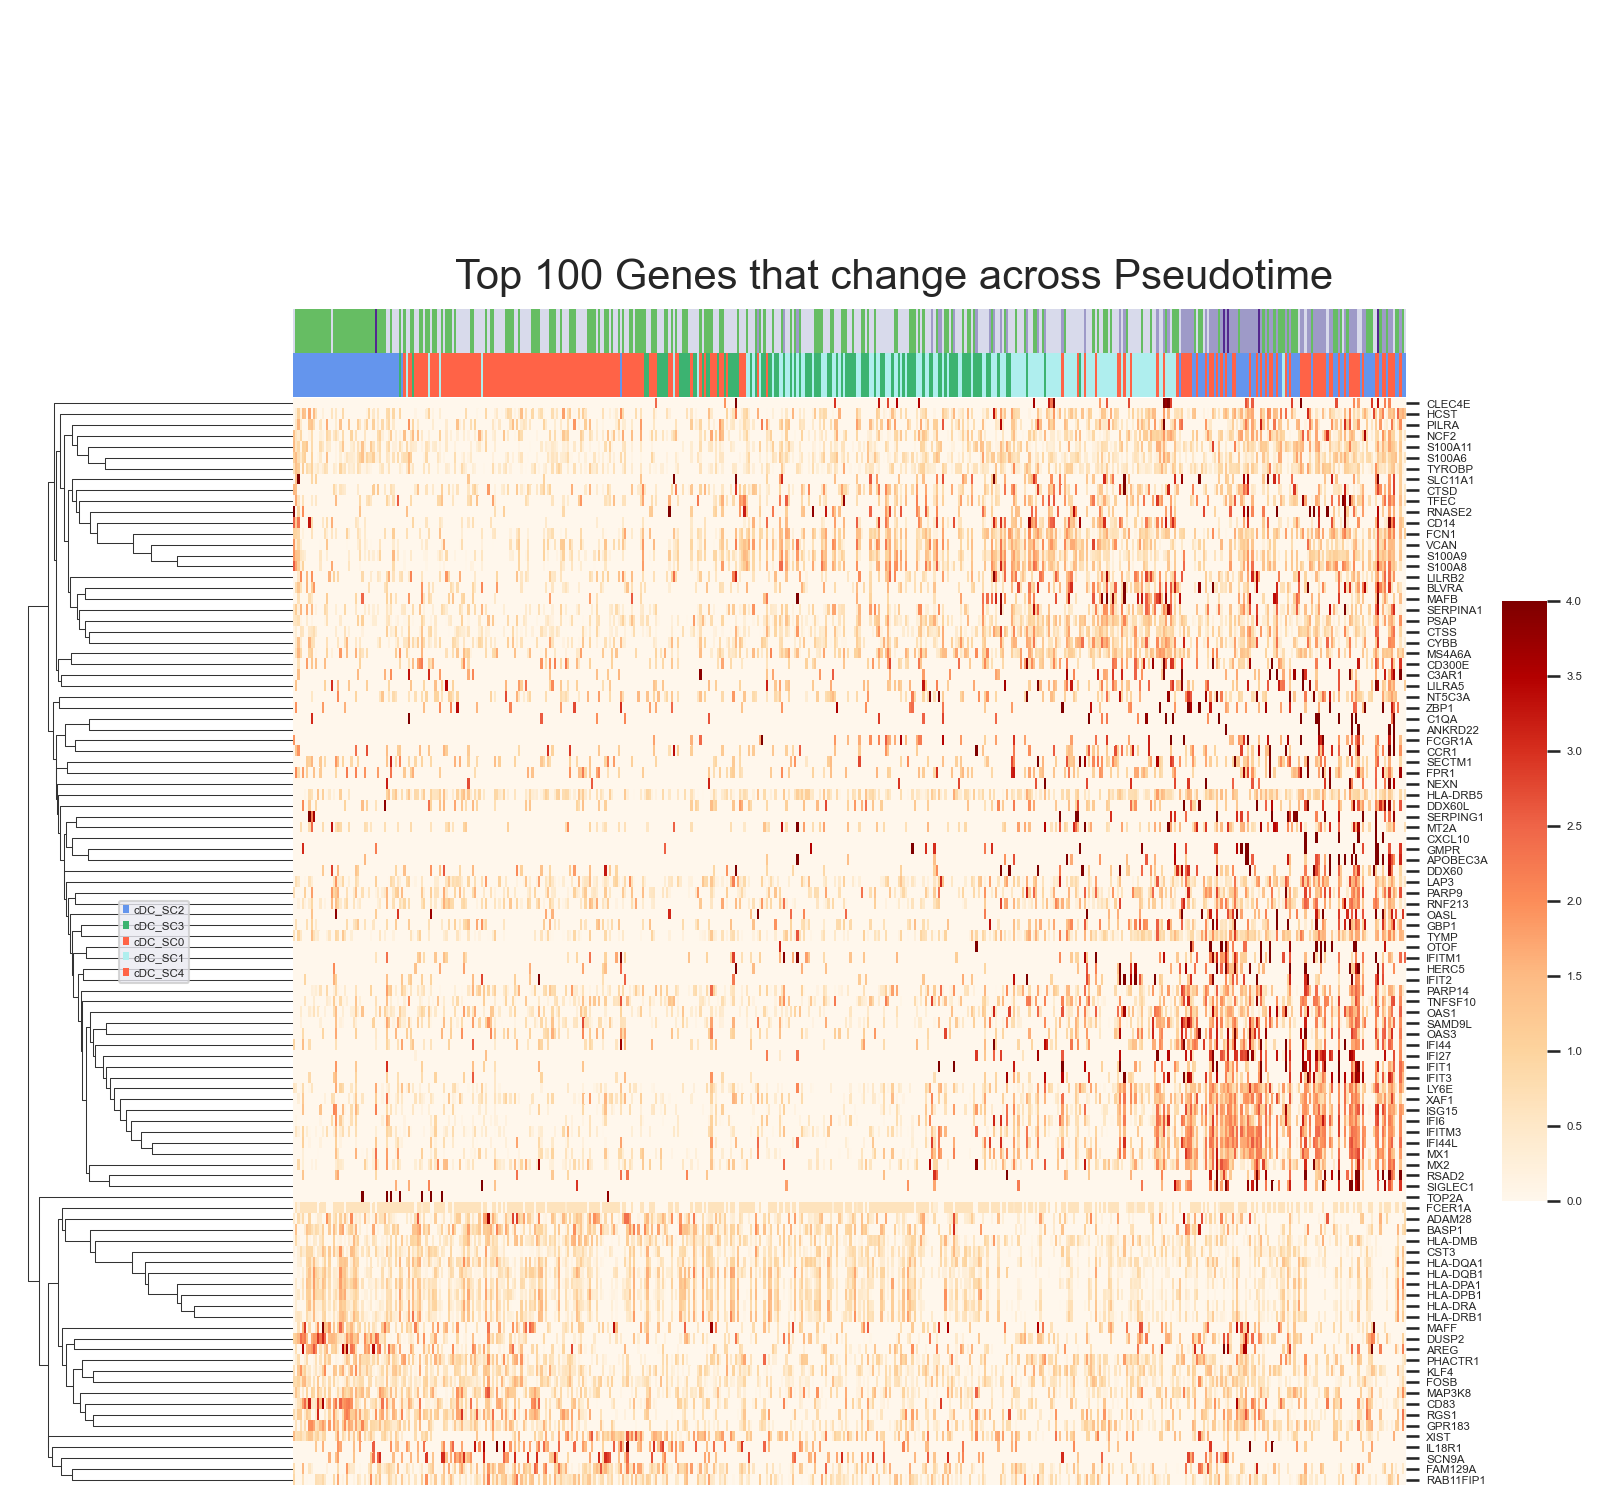

In [80]:
sb.set(font_scale=.5)
g = sb.clustermap(heatdata, cmap = 'OrRd', 
             col_colors = [pGroups_colors,SCs_colors],
             z_score=-4,
             vmin=0, vmax=4,
             row_cluster=True, col_cluster=False,
             linewidths=0, xticklabels=False, yticklabels=True, cbar_pos=(1, .2, .03, .4),
             annot_kws={"fontsize":8}
)

for label in pGroups.unique():
    g.ax_col_dendrogram.bar(0, 0, color=pGroups_dict[label],
                            label=label, linewidth=0)
for label in SCs.unique():
    g.ax_row_dendrogram.bar(0, 0, color=SCs_dict[label],
                            label=label, linewidth=0)

#g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.ax_row_dendrogram.legend(loc="center", ncol=1)

plt.title('Top 100 Genes that change across Pseudotime',x=-13.5, y=1.5, fontsize=20)
plt.savefig('./cDCs_07292021/pseudotime_heatmap.png')
plt.show()